In [20]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential , load_model
from keras.layers import LSTM, Dense
import os
import tensorflow as tf

In [2]:
api_key = "Jpdzf05nPJhqVB5qpNZx2VbmhwVF1spP"

symbol = "MSFT"

end_date = "2024-08-22"
start_date = "2019-08-22"


url = f'https://api.polygon.io/v2/aggs/ticker/{symbol}/range/1/day/{start_date}/{end_date}?adjusted=true&sort=asc&limit=50000&apiKey={api_key}'


response = requests.get(url)
data = response.json()


if response.status_code == 200 and 'results' in data:

    df = pd.DataFrame(data['results'])
    
    df['date'] = pd.to_datetime(df['t'], unit='ms')

    df = df[['date', 'o', 'h', 'l', 'c', 'v', 'vw']]
    df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP']

    print(df.head())
else:
    print("Veri çekilemedi:", data)

                 Date      Open    High     Low   Close      Volume      VWAP
0 2019-08-22 04:00:00  138.6600  139.20  136.29  137.78  18709662.0  137.6093
1 2019-08-23 04:00:00  137.1897  138.35  132.80  133.39  38515386.0  134.5182
2 2019-08-26 04:00:00  134.9900  135.56  133.90  135.45  20325271.0  134.9855
3 2019-08-27 04:00:00  136.3900  136.72  134.66  135.74  23106835.0  135.8088
4 2019-08-28 04:00:00  134.8800  135.76  133.55  135.56  17410828.0  135.0154


In [4]:
print(df)

                    Date      Open      High     Low   Close      Volume  \
0    2019-08-22 04:00:00  138.6600  139.2000  136.29  137.78  18709662.0   
1    2019-08-23 04:00:00  137.1897  138.3500  132.80  133.39  38515386.0   
2    2019-08-26 04:00:00  134.9900  135.5600  133.90  135.45  20325271.0   
3    2019-08-27 04:00:00  136.3900  136.7200  134.66  135.74  23106835.0   
4    2019-08-28 04:00:00  134.8800  135.7600  133.55  135.56  17410828.0   
...                  ...       ...       ...     ...     ...         ...   
1254 2024-08-16 04:00:00  420.6000  421.3400  417.30  418.47  21201583.0   
1255 2024-08-19 04:00:00  418.9600  421.7500  416.46  421.53  14419960.0   
1256 2024-08-20 04:00:00  421.7000  425.8600  421.64  424.80  15778630.0   
1257 2024-08-21 04:00:00  424.0750  426.4000  421.72  424.14  14809439.0   
1258 2024-08-22 04:00:00  424.3600  426.7899  414.61  415.55  18284617.0   

          VWAP  
0     137.6093  
1     134.5182  
2     134.9855  
3     135.8088  
4 

In [6]:
total_length = len(df)
print(f"df'in toplam veri uzunluğu: {total_length}")

df'in toplam veri uzunluğu: 1259


In [7]:
close_data = df[['Date', 'Close']].set_index('Date')
close_data

,Close
Date,
2019-08-22 04:00:00,137.78
2019-08-23 04:00:00,133.39
2019-08-26 04:00:00,135.45
2019-08-27 04:00:00,135.74
2019-08-28 04:00:00,135.56
...,...
2024-08-16 04:00:00,418.47
2024-08-19 04:00:00,421.53
2024-08-20 04:00:00,424.80


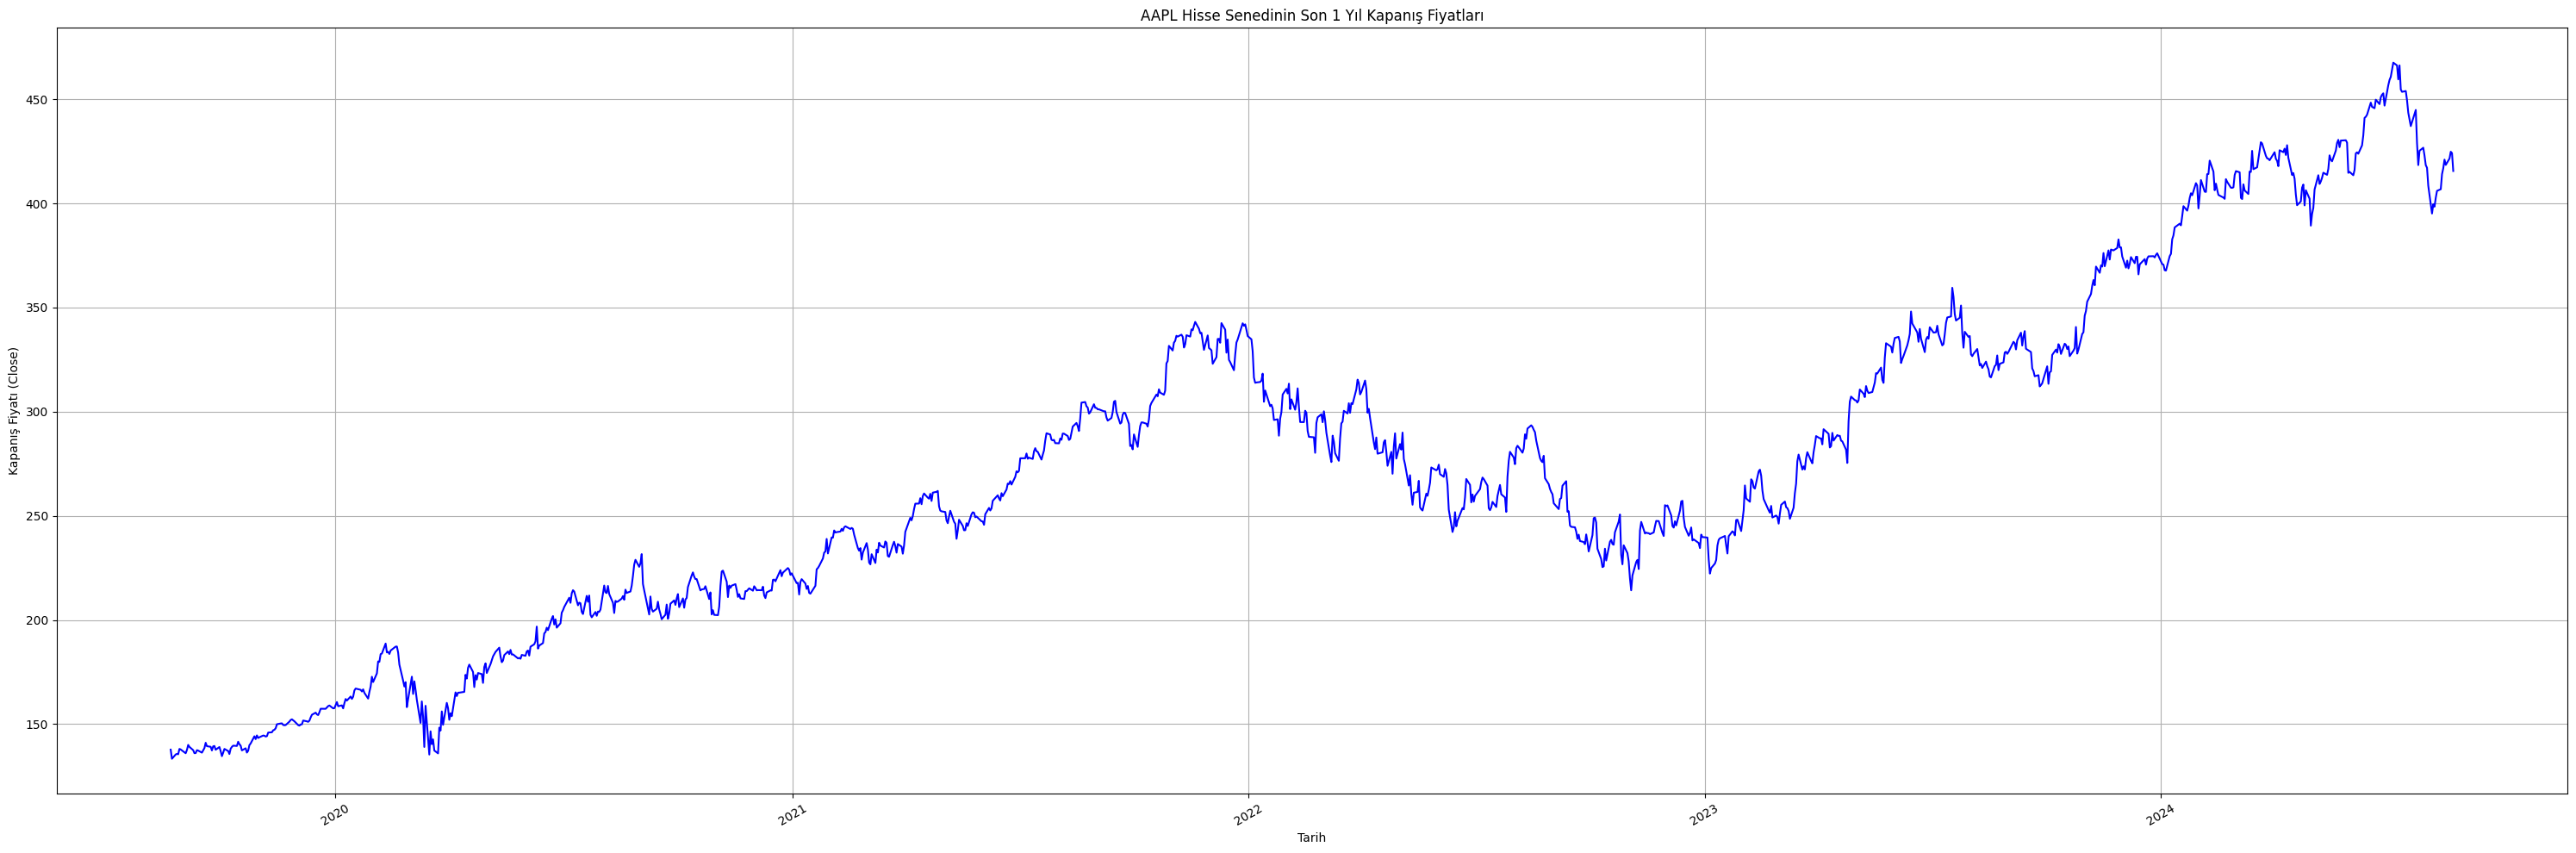

In [8]:
plt.figure(figsize=(30, 10))
plt.plot(df['Date'], df['Close'], marker='', linestyle='-', color='blue')

plt.title('AAPL Hisse Senedinin Son 1 Yıl Kapanış Fiyatları')
plt.xlabel('Tarih')
plt.ylabel('Kapanış Fiyatı (Close)')
plt.grid(True)
plt.xticks(rotation=30)  
plt.tight_layout()

plt.show()

In [9]:
data = close_data['Close'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

training_data_len = math.ceil(len(scaled_data) * 0.9)
train_data = scaled_data[:training_data_len]  # Eğitim verisi
test_data = scaled_data[training_data_len:]   # Test verisi

data_dict = {
    "train_data": train_data,
    "test_data": test_data
}

print(f"AAPL Eğitim verisi uzunluğu: {len(train_data)}")
print(f"AAPL Test verisi uzunluğu: {len(test_data)}")


training_data_lengths = {
    "AAPL": training_data_len
}
print("Veriler dict'e başarıyla eklendi.")

AAPL Eğitim verisi uzunluğu: 1134
AAPL Test verisi uzunluğu: 125
Veriler dict'e başarıyla eklendi.


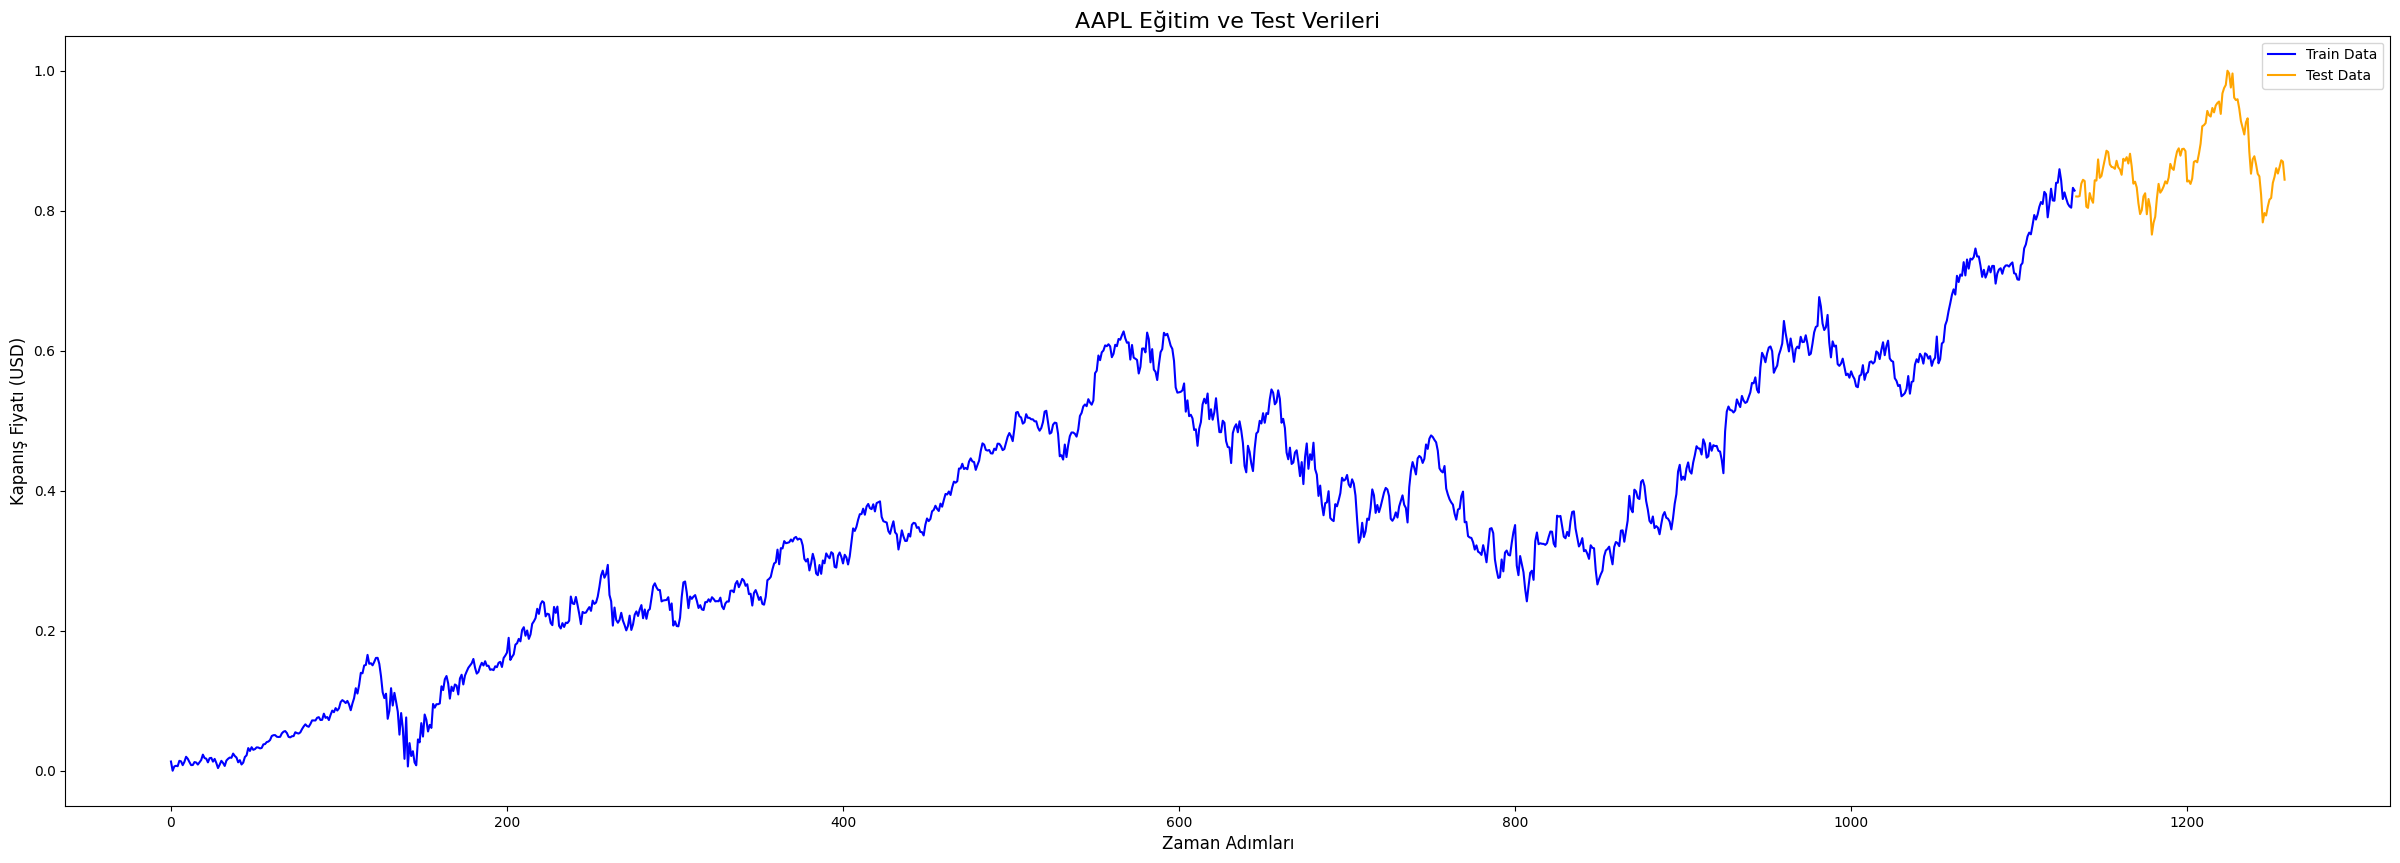

In [10]:
train_index = range(training_data_len)  
test_index = range(training_data_len, training_data_len + len(test_data))
plt.figure(figsize=(30, 10))

plt.plot(train_index, train_data, label='Train Data', color='blue')

plt.plot(test_index, test_data, label='Test Data', color='orange')

plt.title("AAPL Eğitim ve Test Verileri", fontsize=16)
plt.xlabel("Zaman Adımları", fontsize=12)
plt.ylabel("Kapanış Fiyatı (USD)", fontsize=12)

plt.legend()

plt.show()

In [11]:
print(f"Train Data Mean: {train_data.mean()}")
print(f"Train Data Min: {train_data.min()}")
print(f"Train Data Max: {train_data.max()}")

Train Data Mean: 0.3719090347777344
Train Data Min: 0.0
Train Data Max: 0.8593230990214562


In [12]:
print(f"TEST Data Mean: {test_data.mean()}")
print(f"TEST Data Min: {test_data.min()}")
print(f"TEST Data Max: {test_data.max()}")

TEST Data Mean: 0.8688442409552025
TEST Data Min: 0.7658975970314512
TEST Data Max: 1.0000000000000002


In [13]:
scaled_data_dict = {} #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
scaled_data_dict['MSFT'] = scaled_data

training_data_len = math.ceil(len(scaled_data) * 0.9)
training_data_lengths = {}
training_data_lengths['MSFT'] = training_data_len

In [14]:
x_train_dict = {}
y_train_dict = {}

symbol = 'MSFT'

scaled_data = scaled_data_dict[symbol]
train_data_len = training_data_lengths[symbol]
train_data = scaled_data[:train_data_len, :]

x_train = []
y_train = []

for i in range(5, len(train_data)):
    x_train.append(train_data[i-5:i, 0])  # x_train: Son 120 zaman adımını içerir
    y_train.append(train_data[i, 0])  # y_train: Bir sonraki zaman adımını içerir

x_train = np.array(x_train)
y_train = np.array(y_train)

x_train_dict[symbol] = x_train
y_train_dict[symbol] = y_train

print(f"{symbol} x_train shape: {x_train_dict[symbol].shape}")
print(f"{symbol} y_train shape: {y_train_dict[symbol].shape}")


print(f"x_train first entry: {x_train_dict[symbol][0]}")
print(f"y_train first entry: {y_train_dict[symbol][0]}")

MSFT x_train shape: (1129, 5)
MSFT y_train shape: (1129,)
x_train first entry: [0.01313703 0.         0.00616453 0.00703235 0.0064937 ]
y_train first entry: 0.014154472274590824


In [15]:
# Test verisini oluşturma
x_test = []
y_test = []

for i in range(5, len(test_data)):
    x_test.append(test_data[i-5:i])  # x_test: Son xxx zaman adımını içerir
    y_test.append(test_data[i])  # y_test: Bir sonraki zaman adımını içerir


x_test = np.array(x_test)
y_test = np.array(y_test)


x_test_dict = {}
y_test_dict = {}

x_test_dict[symbol] = x_test
y_test_dict[symbol] = y_test

print(f"{symbol} x_test shape: {x_test_dict[symbol].shape}")
print(f"{symbol} y_test shape: {y_test_dict[symbol].shape}")

print(f"x_test first entry: {x_test_dict[symbol][0]}")
print(f"y_test first entry: {y_test_dict[symbol][0]}")

MSFT x_test shape: (120, 5, 1)
MSFT y_test shape: (120, 1)
x_test first entry: [[0.82039082]
 [0.82021127]
 [0.82092947]
 [0.838645  ]
 [0.84421103]]
y_test first entry: [0.84247539]


In [16]:
#yeniden şekillendirme

reshaped_x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Sonuçları ekrana yazdırma
print("Symbol: MSFT")
print(f"Reshaped x_train shape: {reshaped_x_train.shape}")

Symbol: MSFT
Reshaped x_train shape: (1129, 5, 1)


In [17]:
reshaped_y_test = np.reshape(y_test, (y_test.shape[0], 1))

# Sonuçları ekrana yazdırma
print("Symbol: MSFT")
print(f"Reshaped y_test shape: {reshaped_y_test.shape}")

Symbol: MSFT
Reshaped y_test shape: (120, 1)


In [21]:

input_shape = (5, 1)  # xx gün önceki veriyi kullanarak tahmin yapacağız
def create_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanAbsoluteError()])
    return model
model = create_model(input_shape)
model.summary()


/Users/tbai/Documents/Vsanaliz/analiz/vproject2/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 5, 128)         │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,619 (459.45 KB)

 Trainable params: 117,619 (459.45 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
save_dir = "trained_models_MSFT"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

x_train = reshaped_x_train
y_train = y_train

#eğitim aşaması
model = create_model((x_train.shape[1], 1))
history = model.fit(x_train, y_train, batch_size=1, epochs=25, verbose=1)


model_path = os.path.join(save_dir, "MSFT_model1.h5")
model.save(model_path)
print(f"AAPL modeli kaydedildi: {model_path}")

saved_files = os.listdir(save_dir)
print("Kaydedilen modeller:", saved_files)

Epoch 1/25
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - loss: 0.0036 - mean_absolute_error: 0.0362
Epoch 2/25
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 8.4246e-04 - mean_absolute_error: 0.0223
Epoch 3/25
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 7.9579e-04 - mean_absolute_error: 0.0218
Epoch 4/25
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 6.3574e-04 - mean_absolute_error: 0.0193
Epoch 5/25
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 5.1046e-04 - mean_absolute_error: 0.0174
Epoch 6/25
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 4.9153e-04 - mean_absolute_error: 0.0173
Epoch 7/25
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 4.3455e-04 - mean_absolute_error: 0.0162
Epoch 8/25
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 3.7186e-04 - mean_absolute_error: 0.0145
Epoch 9/25
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 3.6928e-04 - mean_absolute_error: 0.0152
Epoch 10/25
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - 

AAPL modeli kaydedildi: trained_models_MSFT/MSFT_model1.h5
Kaydedilen modeller: ['MSFT_model1.h5']


In [23]:
loaded_models = {}

save_dir = "trained_models_MSFT"
model_path = os.path.join(save_dir, "MSFT_model4.h5")


if os.path.exists(model_path):
    loaded_models["MSFT"] = load_model(model_path)
    print(f"Model yüklendi: {model_path}")
else:
    print(f"Model dosyası bulunamadı: {model_path}")

print(f"AAPL // -> {model_path} modeli başarıyla yüklendi.")

Model dosyası bulunamadı: trained_models_MSFT/MSFT_model4.h5
AAPL // -> trained_models_MSFT/MSFT_model4.h5 modeli başarıyla yüklendi.


In [25]:
symbol = "MSFT"
predictions_dict = {}

print(f"{symbol} için tahmin yapılıyor...")

model_path = os.path.join(save_dir, f"{symbol}_model1.h5")

if os.path.exists(model_path):
    loaded_model = load_model(model_path)
else:
    print(f"Model dosyası bulunamadı: {model_path}")
    raise FileNotFoundError(f"Model dosyası bulunamadı: {model_path}")


batch_size = 5
predictions = loaded_model.predict(x_test, batch_size=batch_size)

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df['Close'].values.reshape(-1, 1))
predictions = scaler.inverse_transform(predictions)
predictions_dict[symbol] = predictions
print(f"{symbol} için tahmin edilen değerler: \n{predictions}")

MSFT için tahmin yapılıyor...
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MSFT için tahmin edilen değerler: 
[[409.56168]
 [409.61505]
 [398.37268]
 [399.21063]
 [404.39398]
 [401.24124]
 [400.40775]
 [409.91647]
 [408.65897]
 [419.55017]
 [409.50247]
 [413.46066]
 [415.4218 ]
 [419.43076]
 [422.94757]
 [422.2373 ]
 [417.53632]
 [417.06094]
 [416.34708]
 [415.76886]
 [419.19202]
 [415.6168 ]
 [415.71185]
 [412.76907]
 [420.38297]
 [418.00983]
 [420.96393]
 [417.30154]
 [422.72998]
 [415.8912 ]
 [409.94635]
 [410.54135]
 [407.21335]
 [400.7037 ]
 [395.95685]
 [397.36166]
 [402.8323 ]
 [403.5686 ]
 [394.7429 ]
 [402.49445]
 [396.98044]
 [386.80524]
 [391.91104]
 [393.14215]
 [401.8517 ]
 [406.92526]
 [403.5386 ]
 [405.86172]
 [406.92896]
 [409.5983 ]
 [408.37854]
 [411.45877]
 [417.01215]
 [414.78415]
 [415.14804]
 [419.54807]
 [422.58792]
 [424.1918 ]
 [421.02124]
 [424.7597 ]
 [424.009  ]
 [423.6732 ]
 [410.06335]
 [412.18805]
 [408.65146]
 [411.8157 ]
 [418.00378]
 [417.88477]
 [418.2328 ]

In [26]:
final_predictions_dict = {}
final_y_test_dict = {}


if symbol in predictions_dict:
    predictions = predictions_dict[symbol]
    y_test = y_test  

    min_len = min(len(predictions), len(y_test))
    predictions = predictions[:min_len]
    y_test = y_test[:min_len]


    final_predictions_dict[symbol] = predictions
    final_y_test_dict[symbol] = y_test

    print(f"{symbol} için hizalanmış uzunluklar:")
    print(f"predictions length: {len(predictions)}, y_test length: {len(y_test)}\n")
else:
    print(f"{symbol} için tahminler bulunamadı.")

print("AAPL tahminleri ve y_test uzunlukları başarıyla hizalanmıştır.")

MSFT için hizalanmış uzunluklar:
predictions length: 120, y_test length: 120

AAPL tahminleri ve y_test uzunlukları başarıyla hizalanmıştır.


In [27]:
predictions = final_predictions_dict[symbol].flatten() # düzleştirdikkk
y_test = final_y_test_dict[symbol].flatten()

mape = np.mean(np.abs(predictions - y_test)/np.abs(y_test))
rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
me = np.mean(predictions - y_test)
corr = np.corrcoef(predictions, y_test)[0, 1] 

print(f"{symbol} RMSE: {rmse}\n")
print(f"{symbol} mape: {mape}\n")
print(f"{symbol} me: {me}\n")
print(f"{symbol} korelasyon: {corr}\n")
rmse_dict = {symbol: rmse}  
mape_dict = {symbol: mape}
mape_dict = {symbol: me}
mape_dict = {symbol: corr}

print(f"Metriği test edilen hisse: {symbol}...")

print("Metrik hesaplamaları tamamlandı.")

MSFT RMSE: 418.2521681510611

MSFT mape: 480.7349260195391

MSFT me: 417.92949047889795

MSFT korelasyon: 0.9509319863715683

Metriği test edilen hisse: MSFT...
Metrik hesaplamaları tamamlandı.


In [28]:
print(close_data.keys()) 

Index(['Close'], dtype='object')


In [29]:
print(close_data.columns) 

Index(['Close'], dtype='object')


In [30]:
print(close_data)

                      Close
Date                       
2019-08-22 04:00:00  137.78
2019-08-23 04:00:00  133.39
2019-08-26 04:00:00  135.45
2019-08-27 04:00:00  135.74
2019-08-28 04:00:00  135.56
...                     ...
2024-08-16 04:00:00  418.47
2024-08-19 04:00:00  421.53
2024-08-20 04:00:00  424.80
2024-08-21 04:00:00  424.14
2024-08-22 04:00:00  415.55

[1259 rows x 1 columns]


In [31]:
print(close_data.keys())

Index(['Close'], dtype='object')


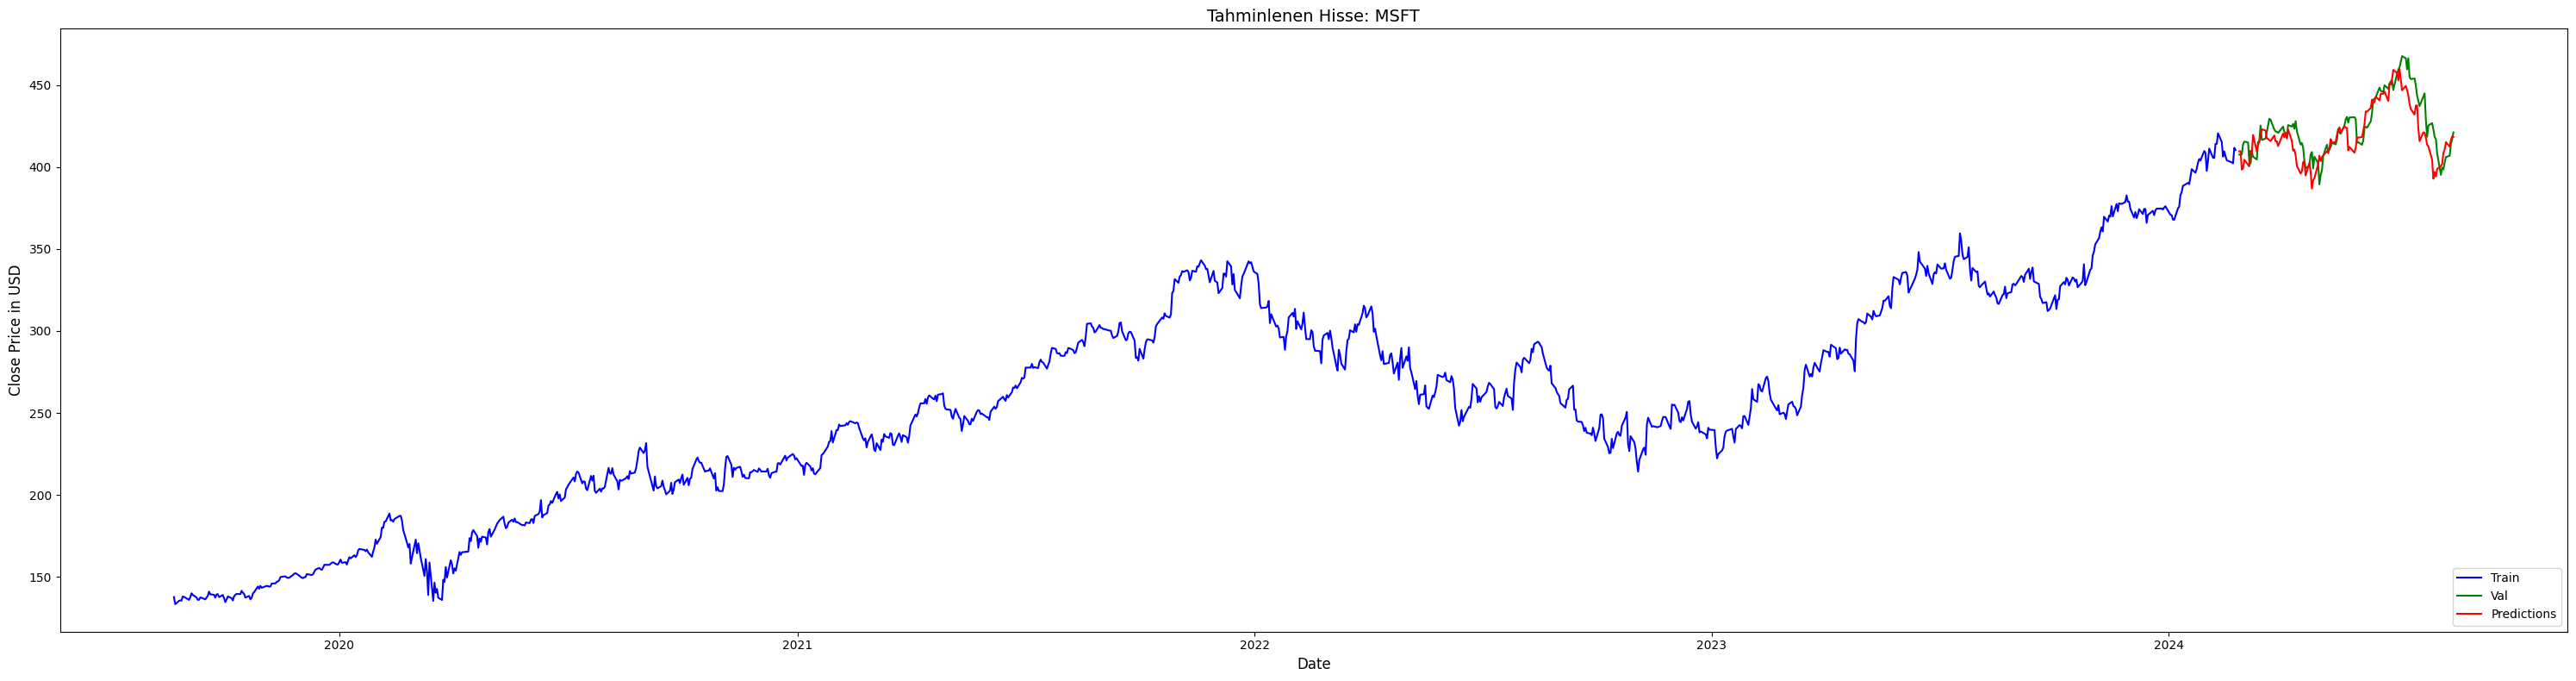

MSFT için grafik oluşturuldu.


In [34]:
data = close_data['Close']  

training_data_len = training_data_lengths['MSFT']  # Eğitim verisi uzunluğunu alıyoruz
train = data[:training_data_len]  # Eğitim verisi
valid = data[training_data_len:]  # Validasyon verisi

valid = pd.DataFrame(valid)

min_len = min(len(valid), len(final_predictions_dict['MSFT']))
valid = valid.iloc[:min_len].copy()  
valid["Predictions"] = final_predictions_dict['MSFT'][:min_len]

fig, ax = plt.subplots(figsize=(30, 8))  

ax.set_title(f"Tahminlenen Hisse: MSFT", fontsize=14)
ax.plot(train.index, train.values, label="Train", color="blue")
ax.plot(valid.index, valid['Close'], label="Val", color="green")
ax.plot(valid.index, valid["Predictions"], label="Predictions", color="red")
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Close Price in USD", fontsize=12)
ax.legend(["Train", "Val", "Predictions"], loc="lower right", fontsize=10)

plt.tight_layout()
plt.show()

print("MSFT için grafik oluşturuldu.")

In [36]:
model_path = '/Users/tbai/Documents/Vsanaliz/analiz/project/ABD/trained_models_MSFT/MSFT_model1.h5'
model = load_model(model_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


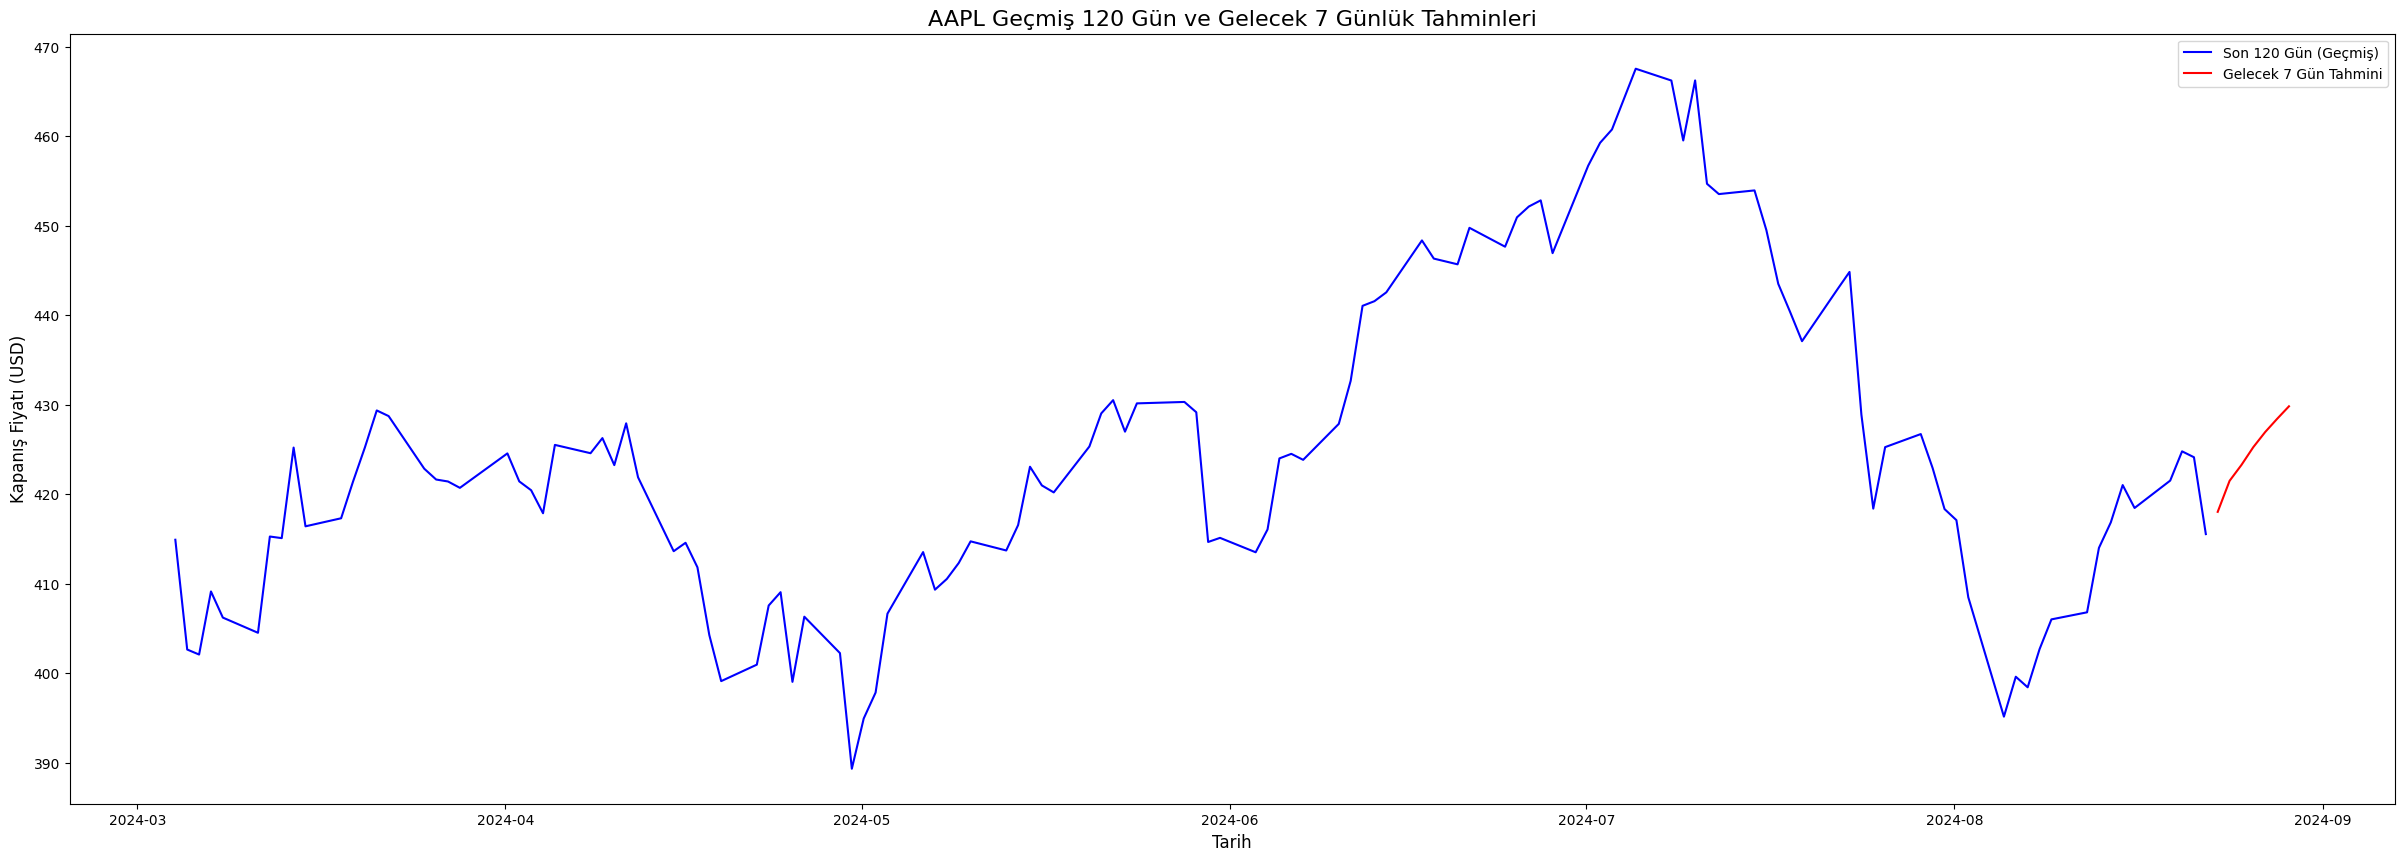

In [37]:
# Tahmin etmek istediğiniz gün sayısı
num_days = 7

last_120_days = scaled_data[-120:] 
original_last_120_days = scaler.inverse_transform(last_120_days) 

predictions = []

for _ in range(num_days):

    X_input = last_120_days.reshape((1, 120, 1))

    pred = model.predict(X_input)

    predictions.append(pred[0][0])

    last_120_days = np.append(last_120_days[1:], pred[0])

predictions = np.array(predictions).reshape(-1, 1)
predictions_original_scale = scaler.inverse_transform(predictions)
last_120_days_dates = close_data.index[-120:]

future_dates = pd.date_range(last_120_days_dates[-1] + pd.Timedelta(days=1), periods=num_days)
plt.figure(figsize=(30, 10))

plt.plot(last_120_days_dates, original_last_120_days, label='Son 120 Gün (Geçmiş)', color='blue')

plt.plot(future_dates, predictions_original_scale, label=f'Gelecek {num_days} Gün Tahmini', color='red')

plt.title(f"AAPL Geçmiş 120 Gün ve Gelecek {num_days} Günlük Tahminleri", fontsize=16)
plt.xlabel("Tarih", fontsize=12)
plt.ylabel("Kapanış Fiyatı (USD)", fontsize=12)
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


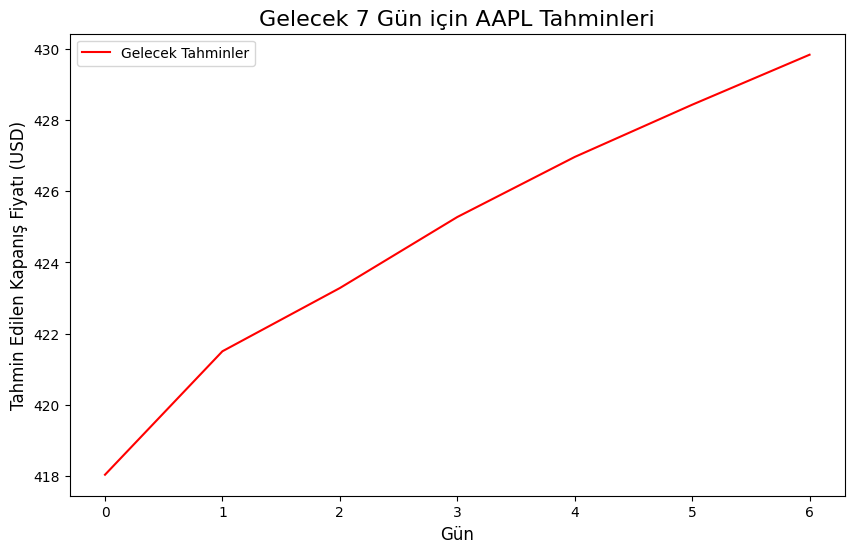

In [38]:
num_days = 7

last_120_days = scaled_data[-120:]

predictions = []
for _ in range(num_days):

    X_input = last_120_days.reshape((1, 120, 1))
    pred = model.predict(X_input)
    predictions.append(pred[0][0])
    last_120_days = np.append(last_120_days[1:], pred[0])

predictions = np.array(predictions).reshape(-1, 1)
predictions_original_scale = scaler.inverse_transform(predictions)

plt.figure(figsize=(10, 6))
plt.plot(predictions_original_scale, label='Gelecek Tahminler', color='red')
plt.title(f"Gelecek {num_days} Gün için AAPL Tahminleri", fontsize=16)
plt.xlabel("Gün", fontsize=12)
plt.ylabel("Tahmin Edilen Kapanış Fiyatı (USD)", fontsize=12)
plt.legend()
plt.show()

In [39]:
predictions = []
for _ in range(num_days):
    X_input = last_120_days.reshape((1, 120, 1))

    pred = model.predict(X_input)

    predictions.append(pred[0][0])

    last_120_days = np.append(last_120_days[1:], pred[0])

predictions = np.array(predictions).reshape(-1, 1)
predictions_original_scale = scaler.inverse_transform(predictions)

last_120_days_dates = close_data.index[-120:]

future_dates = pd.date_range(last_120_days_dates[-1] + pd.Timedelta(days=1), periods=num_days)

all_dates = np.concatenate([last_120_days_dates, future_dates])
all_values = np.concatenate([original_last_120_days.flatten(), predictions_original_scale.flatten()])

df = pd.DataFrame({
    'Tarih': all_dates,
    'Kapanış Fiyatı (USD)': all_values
})

print(df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
                  Tarih  Kapanış Fiyatı (USD)
0   2024-03-04 05:00:00            414.920000
1   2024-03-05 05:00:00            402.650000
2   2024-03-06 05:00:00            402.090000
3   2024-03-07 05:00:00            409.140000
4   2024-03-08 05:00:00            406.220000
..                  ...                   ...
122 2024-08-25 04:00:00            433.886169
123 2024-08-26 04:00:00            435.178619
124 2024-08-27 04:00:00            436.437439
125 2024-08-28 04:00:00            437.662933
126 2024-08-29 04:00:00            438.855499

[127 rows x 2 columns]
